# Best Neighborhood in Pittsburgh

## Members：Jared Glickfield, Aoxue Ding, Jackson Lustina
## Group Name: Team Panthers

---

## Analysis: 
#### 1. Metric: <br>
   #### Polling Locations, Parks, COVID Cases<br>
#### 2. Data Resource: <br>
   #### Polling Locations: https://data.wprdc.org/dataset/allegheny-county-polling-place-locations-may-20181 <br>
   #### Neighborhoods: https://data.wprdc.org/dataset/neighborhoods1  <br>
   #### Parks: https://data.wprdc.org/dataset/parks1 <br>
   #### COVID Cases:https://data.wprdc.org/dataset/parks1 <br> 
#### 3.Weights 
      ????
---

## Jared Glickfield: Park Map

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### Importing General Files

In [42]:
neighborhood = gpd.read_file("Neighborhoods_.geojson")
neighborhoodCopy = neighborhood.copy()

#### Getting Park data into df

In [43]:
parks = gpd.read_file("jbg53Files/Pittsburgh_Parks.geojson")
parkNum = pd.DataFrame(neighborhood.objectid, columns=['objectid', 'parks'])
for index, n in neighborhood.iterrows():
    numOfParks = 0 
    for index, p in parks.iterrows():
        if n.geometry.intersects(p.geometry):
            numOfParks += 1
            parks.drop([index])
    parkNum.at[parkNum[parkNum['objectid'] == n.objectid].index.values[0], 'parks'] = numOfParks

neighborhood.insert(1, 'parks', parkNum.parks)

#### Getting Cases data into df

In [44]:
d3 = pd.read_csv("Covid-19 Analysis/3.csv")
num_cases = d3.groupby("neighborhood_municipality").sum()['cases']

In [45]:
neighborhood['hood'] = neighborhood['hood'] + ' (Pittsburgh)'
neighborhood = neighborhood.merge(num_cases, how='left', left_on='hood', right_on='neighborhood_municipality')

In [46]:
neighborhood['hood'] = neighborhoodCopy['hood']

#### Getting Polling data into df

In [47]:
poll = gpd.read_file("jcl109Files/Polling.geojson")
pollNum = pd.DataFrame(neighborhood.objectid , columns = ['objectid','polling'])
for index, n in neighborhood.iterrows():
    numOfPolls = 0
    for index, p in poll.iterrows():
        if n.geometry.intersects(p.geometry):
             numOfPolls +=1
    pollNum.at[pollNum[pollNum['objectid'] == n.objectid].index.values[0],'polling'] = numOfPolls
neighborhood.insert(1 ,'polling', pollNum.polling)

In [48]:
neighborhood_ = neighborhood

#### Metric Calculation
We want final metric to run from 0 to 1 so we set a percentage for each metric 
parks are worth .3, cases are work .5 and polling locations are worth .3

We then map using np.interp all values from 0 to 1

Then we do some math and 

In [70]:
neighborhood = neighborhood[['hood', 'parks', 'cases', 'polling', 'geometry']]
neighborhood.insert(1 ,'metric', np.nan)
neighborhood.parks = np.interp(neighborhood.parks, [0, neighborhood.parks.max()], [0,1])
neighborhood.cases = np.interp(neighborhood.cases, [0, neighborhood.cases.max()], [0,1])
neighborhood.cases = 1 - neighborhood.cases
neighborhood.cases = neighborhood.cases.fillna(.5)
neighborhood.polling = np.interp(neighborhood.polling, [0, neighborhood.polling.max()], [0,1])

neighborhood.metric = .2 * neighborhood.parks + .5 * neighborhood.cases + .3 * neighborhood.polling

In [81]:
neighborhood = neighborhood.sort_values('metric', ascending = False)
neighborhood

,hood,metric,parks,cases,polling,geometry,center
53,Point Breeze,0.706266,0.833333,0.869198,0.35,"POLYGON ((-79.89319 40.44649, -79.89391 40.443...",POINT (-79.90765 40.44571)
78,Beechview,0.659072,0.583333,0.784810,0.50,"POLYGON ((-80.02121 40.42342, -80.02111 40.423...",POINT (-80.02458 40.41263)
35,East Liberty,0.655886,0.916667,0.675105,0.45,"POLYGON ((-79.91580 40.46081, -79.91577 40.460...",POINT (-79.92461 40.46467)
8,Troy Hill,0.609367,0.500000,0.898734,0.20,"MULTIPOLYGON (((-79.97766 40.46653, -79.97771 ...",POINT (-79.98300 40.46280)
47,Hazelwood,0.608186,0.500000,0.776371,0.40,"POLYGON ((-79.95505 40.42713, -79.95498 40.427...",POINT (-79.94114 40.41238)
...,...,...,...,...,...,...,...
76,Carrick,0.424093,0.250000,0.388186,0.60,"POLYGON ((-79.99194 40.40719, -79.99191 40.407...",POINT (-79.98605 40.39496)
59,Glen Hazel,0.331245,0.083333,0.599156,0.05,"POLYGON ((-79.92030 40.41205, -79.92027 40.412...",POINT (-79.93044 40.40601)
31,Shadyside,0.323734,0.166667,0.130802,0.75,"POLYGON ((-79.92238 40.46055, -79.92208 40.460...",POINT (-79.93233 40.45349)
46,Bluff,0.286941,0.083333,0.510549,0.05,"POLYGON ((-79.99390 40.43893, -79.99381 40.438...",POINT (-79.98495 40.43635)


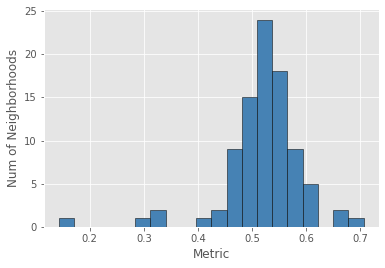

In [95]:
fig, ax = plt.subplots()
ax.set_ylabel('Num of Neighborhoods')
ax.set_xlabel('Metric')
plt.style.use('ggplot')
plt.hist(neighborhood.metric, bins = 20, edgecolor = 'k', color = 'steelblue')
plt.show()

#### Map

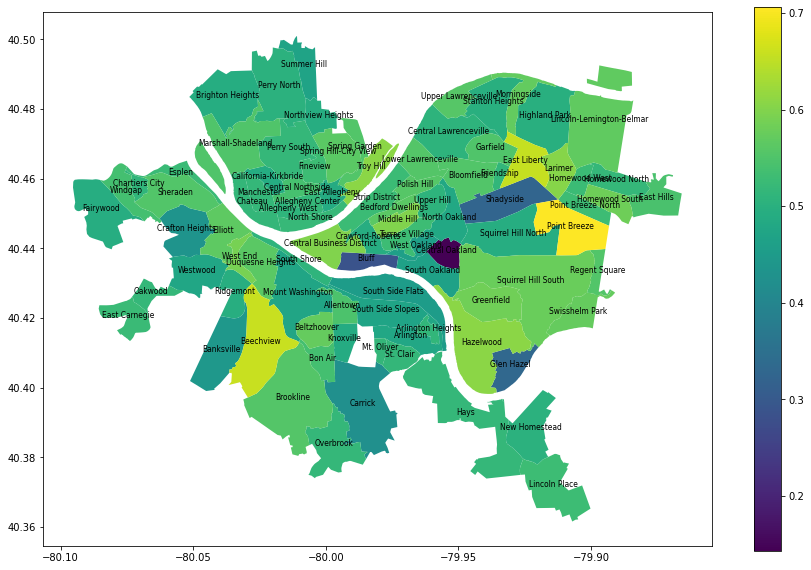

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))

neighborhood['center'] = neighborhood.geometry.centroid

neighborhoodPts = neighborhood.copy()
neighborhoodPts.set_geometry("center", inplace = True)

for x, y, label in zip(neighborhoodPts.geometry.x, neighborhoodPts.geometry.y, neighborhood.hood):
    plt.text(x, y, label, fontsize = 7.5, ha = 'center', weight = '525')
    
neighborhood.plot(column='metric', ax=ax, legend=True)

### What is the best?

In [90]:
neighborhood[['hood', 'metric']].head(10)

,hood,metric
53,Point Breeze,0.706266
78,Beechview,0.659072
35,East Liberty,0.655886
8,Troy Hill,0.609367
47,Hazelwood,0.608186
28,Larimer,0.603924
41,Central Business District,0.599430
43,Middle Hill,0.598924
89,West End,0.590338
49,Greenfield,0.583987


### The worst?

In [88]:
neighborhood[['hood', 'metric']].tail(5)

,hood,metric
76,Carrick,0.424093
59,Glen Hazel,0.331245
31,Shadyside,0.323734
46,Bluff,0.286941
36,Central Oakland,0.143333


---

## Aoxue Ding: COVID Cases

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import geopandas as gpd


In [10]:
d3= pd.read_csv("3.csv")
d3.head(10) 

,neighborhood_municipality,indv_tested,cases,deaths,update_date
0,Aleppo,362,6,0,2020-10-26
1,Allegheny Center (Pittsburgh),195,14,0,2020-10-26
2,Allegheny West (Pittsburgh),94,3,0,2020-10-26
3,Allentown (Pittsburgh),327,30,0,2020-10-26
4,Arlington (Pittsburgh),255,25,1,2020-10-26
5,Arlington Heights (Pittsburgh),52,1,1,2020-10-26
6,Aspinwall,375,16,0,2020-10-26
7,Avalon,731,40,4,2020-10-26
8,Baldwin Borough,3948,585,12,2020-10-26
9,Baldwin Township,264,26,1,2020-10-26


**I used the data from WPRDC. This data shows neighborhoods, the number of individual tested, the number of cases, deaths.** 

In [12]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   neighborhood_municipality  220 non-null    object
 1   indv_tested                220 non-null    int64 
 2   cases                      220 non-null    int64 
 3   deaths                     220 non-null    int64 
 4   update_date                220 non-null    object
dtypes: int64(3), object(2)
memory usage: 8.7+ KB


In [13]:
d3.sample(10)

,neighborhood_municipality,indv_tested,cases,deaths,update_date
86,Greenfield (Pittsburgh),1197,70,4,2020-10-26
2,Allegheny West (Pittsburgh),94,3,0,2020-10-26
131,New Homestead (Pittsburgh),146,21,0,2020-10-26
205,West Deer,1724,57,0,2020-10-26
11,Bedford Dwellings (Pittsburgh),205,21,2,2020-10-26
166,Sewickley Heights,2768,16,0,2020-10-26
7,Avalon,731,40,4,2020-10-26
153,Point Breeze North (Pittsburgh),407,24,0,2020-10-26
75,Forward,328,17,0,2020-10-26
91,Haysville,12,2,0,2020-10-26


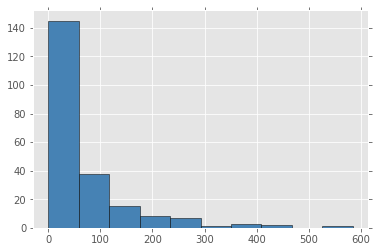

In [14]:
plt.style.use('ggplot')
plt.hist(d3.cases, 
        bins = 10, 
        color = 'steelblue', 
        edgecolor = 'k')
plt.tick_params(top='off', right='off')
plt.show()

**For the bar chart, the y-axis represents the number of neighborhoods, and the x-axis represents the cases. 
We can conclude that most neighborhoods have cases between 0-50, several have cases over 500**

In [15]:
d3.sort_values(by = "cases", ascending = False).head(10)

,neighborhood_municipality,indv_tested,cases,deaths,update_date
8,Baldwin Borough,3948,585,12,2020-10-26
162,Ross,5206,452,41,2020-10-26
144,Penn Hills,6497,436,7,2020-10-26
125,Mount Lebanon,9462,391,3,2020-10-26
215,Whitehall,2418,376,7,2020-10-26
122,Monroeville,5235,352,13,2020-10-26
164,Scott,3119,309,16,2020-10-26
123,Moon,3152,272,9,2020-10-26
117,McKeesport,3554,260,10,2020-10-26
116,McCandless,4601,260,17,2020-10-26


### By ascending cases, we can conculde the most dangerous neighborhood is **Baldwin Borough**

In [16]:
d3.sort_values(by = "cases", ascending = False).tail(10)

,neighborhood_municipality,indv_tested,cases,deaths,update_date
160,Ridgemont (Pittsburgh),378,2,0,2020-10-26
204,Wall,62,2,0,2020-10-26
118,Mcdonald,32,2,0,2020-10-26
40,Chartiers City (Pittsburgh),65,2,0,2020-10-26
91,Haysville,12,2,0,2020-10-26
5,Arlington Heights (Pittsburgh),52,1,1,2020-10-26
128,Mt. Oliver (Pittsburgh),52,0,0,2020-10-26
41,Chateau (Pittsburgh),18,0,0,2020-10-26
195,Trafford,5,0,0,2020-10-26
185,St. Clair (Pittsburgh),23,0,0,2020-10-26


### By ascending cases, we can conculde the most safe neighborhood are **Mt.Oliver, Chateau, Trafford, St.Clair** 

In [18]:
neighborhoods= gpd.read_file("Neighborhoods/Neighborhoods_.shp")

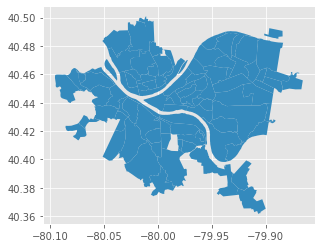

In [19]:
neighborhoods.plot()

In [21]:
num_cases = d3.groupby("neighborhood_municipality").sum()['cases']
num_cases.sort_values(ascending=False)

neighborhood_municipality
Baldwin Borough                   585
Ross                              452
Penn Hills                        436
Mount Lebanon                     391
Whitehall                         376
                                 ... 
Arlington Heights (Pittsburgh)      1
Mt. Oliver (Pittsburgh)             0
Chateau (Pittsburgh)                0
St. Clair (Pittsburgh)              0
Trafford                            0
Name: cases, Length: 220, dtype: int64

In [23]:
neighborhoods[['hood','area','perimeter','geometry']]

,hood,area,perimeter,geometry
0,Central Oakland,7843108.0,11526.863,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,13904629.0,20941.387,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,5999801.5,18271.426,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,7202139.0,15696.759,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,16947852.0,23903.078,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
...,...,...,...,...
85,Ridgemont,10278895.0,16268.131,"POLYGON ((-80.03431 40.43366, -80.03424 40.433..."
86,West End,5579501.0,18776.656,"POLYGON ((-80.02869 40.44454, -80.02845 40.444..."
87,California-Kirkbride,6050988.0,11711.301,"POLYGON ((-80.02039 40.46285, -80.02022 40.462..."
88,Glen Hazel,12713036.0,18931.703,"POLYGON ((-79.92030 40.41205, -79.92027 40.412..."


In [24]:
neighborhoods['hood'] = neighborhoods['hood'] + ' (Pittsburgh)'

In [25]:
neighborhoods[['hood','area','perimeter','geometry']]

,hood,area,perimeter,geometry
0,Central Oakland (Pittsburgh),7843108.0,11526.863,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland (Pittsburgh),13904629.0,20941.387,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland (Pittsburgh),5999801.5,18271.426,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts (Pittsburgh),7202139.0,15696.759,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District (Pittsburgh),16947852.0,23903.078,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
...,...,...,...,...
85,Ridgemont (Pittsburgh),10278895.0,16268.131,"POLYGON ((-80.03431 40.43366, -80.03424 40.433..."
86,West End (Pittsburgh),5579501.0,18776.656,"POLYGON ((-80.02869 40.44454, -80.02845 40.444..."
87,California-Kirkbride (Pittsburgh),6050988.0,11711.301,"POLYGON ((-80.02039 40.46285, -80.02022 40.462..."
88,Glen Hazel (Pittsburgh),12713036.0,18931.703,"POLYGON ((-79.92030 40.41205, -79.92027 40.412..."


In [26]:
# do the merge
cases_map = neighborhoods.merge(num_cases, how='left', left_on='hood', right_on='neighborhood_municipality')
# look at the head to confirm it merged correctly
cases_map[['hood','cases','geometry']].head(10)

,hood,cases,geometry
0,Central Oakland (Pittsburgh),237.0,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland (Pittsburgh),68.0,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland (Pittsburgh),49.0,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts (Pittsburgh),49.0,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District (Pittsburgh),18.0,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
5,Central Business District (Pittsburgh),69.0,"POLYGON ((-79.99238 40.44484, -79.99233 40.444..."
6,Spring Hill-City View (Pittsburgh),30.0,"POLYGON ((-79.99761 40.47460, -79.99761 40.474..."
7,Perry South (Pittsburgh),72.0,"POLYGON ((-80.01456 40.47727, -80.01462 40.477..."
8,Summer Hill (Pittsburgh),14.0,"POLYGON ((-80.01087 40.50097, -80.01073 40.499..."
9,Northview Heights (Pittsburgh),17.0,"POLYGON ((-80.00327 40.48271, -80.00326 40.482..."


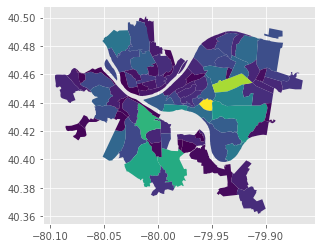

In [27]:
cases_map.plot(column='cases')

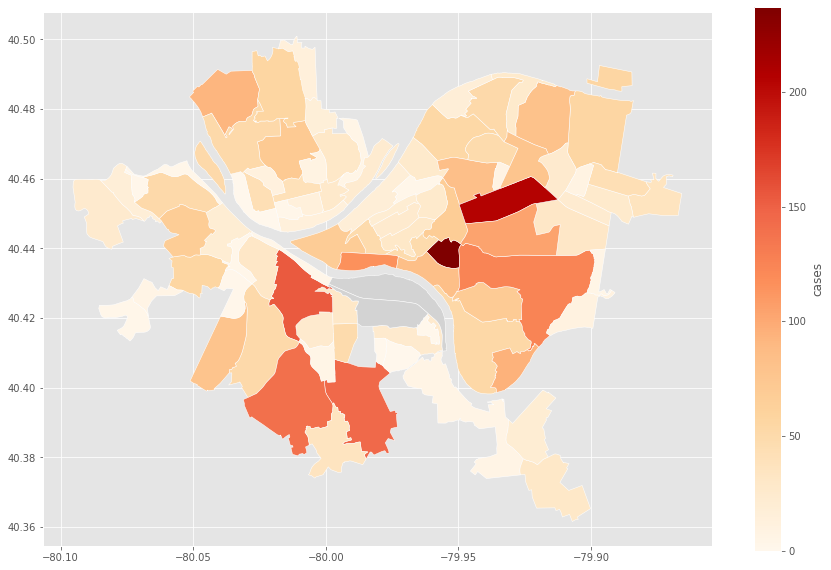

In [28]:
cases_map.plot(column='cases', 
               cmap='OrRd',              
               edgecolor="white",
               legend=True,             
               legend_kwds={'label': "cases"}, 
               figsize=(15, 10),      
               missing_kwds={"color": "lightgrey"} 
               )

### **Conclusion: The most safe neighborhoods are Mt.Oliver, Chateau, Trafford, St.Clair** 

----